# <center> Advanced ML pipeline with segmentation_models and Callbacks
    
---

## **The most important thing to improve your model performance is to understand each and every step taken to build the final model.**

*In this notebook, you will see how we increase our accuracy from 0.18 in previous module to 0.8 in this module.*


# Importing libraries

In [1]:
from matplotlib import pyplot as plt  # Displaying images
from skimage.io import imread         # Read the images
import numpy as np                    # Data Handling
import math                           # Math operations
import os                             # Directory files

# One Hot Encoded Mask and Dataset Building
from tensorflow.keras.utils import to_categorical, Sequence
import tensorflow as tf
import keras

2024-05-09 11:48:07.783503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 11:48:07.783609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 11:48:07.986318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set the root directory paths for images and masks
img_dir = '/kaggle/input/images/render'
mask_dir = '/kaggle/input/images/clean'


# Sort the files in root directories, Create and Store the complete image and mask paths
images = [os.path.join(img_dir, x) for x in sorted(os.listdir(img_dir))]
masks = [os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir))]


# First 8000 images to be used for training
X_train = images[:8000]
y_train = masks[:8000]

# Remaining can be used for validation purpose
X_valid = images[8000:-4]
y_valid = masks[8000:-4]

# Save some for testing purpose (last 4)
X_test = images[-4:]
y_test = masks[-4:]


In [3]:
# Dataset Pipeline 
class LunarDataset(Sequence):

    # Constructor - x_set, y_set, batch_size, dims, classes
    def __init__(self, x_set, y_set, batch_size, dims, classes):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.img_height, self.img_width = dims
        self.classes = classes

    # Number of Batches --> total length of images / batch size --> Ceil operation 
    def __len__(self):
        return math.ceil(len(self.x)/self.batch_size)

    # Fetch the data in batches by using iter and next opertions
    def __getitem__(self, idx):
        # Get start and end indexes to create a batch of batch size
        start_index = idx * self.batch_size
        end_index = (idx + 1) * self.batch_size
        ''' 
        0*2 : 1*2 --> 0:2 --> 0, 1
        1*2 : 2*2 --> 2:4 --> 2, 3
        2*2 : 3*2 --> 4:6 --> 4, 5
        '''

        # Prepare X and y batches
        batch_x = self.x[start_index : end_index]
        batch_y = self.y[start_index : end_index]

        # Empty lists to append preprocessed Images and Masks Array from the for loop
        xtr = []
        ytr = []

        # For every  image and mask in one batch do the following preprocessing
        for idx, (filename_x, filename_y) in enumerate(zip(batch_x, batch_y)):

            # Image preprocessing
            img = imread(filename_x)[:self.img_height, :self.img_width, :]/255.0
            img = img.astype(np.float32)
            xtr.append(img)
           
            # Mask preprocessing
            mask = imread(filename_y, as_gray=True)[:self.img_height, :self.img_width]//0.07 # 0, 1, 3, 10
            mask[mask == 3] = 2
            mask[mask == 10] = 3
            mask = to_categorical(mask, num_classes = self.classes)
            ytr.append(mask)

        # Convert list to arrays ensuring the dtype of mask is also float32
        xtr = np.array(xtr)
        ytr = np.array(ytr).astype(np.float32)

        # Return the preprocessed batch of images and respective mask as output
        return xtr, ytr

### Break Down of Mask Preprocessing


In [4]:
# Consider an example in training data to understand this
mask_sample_path = y_train[1]
print(mask_sample_path)

/kaggle/input/images/clean/clean0002.png


In [5]:
# Read the mask as gray scale
sample_mask_arr = imread(mask_sample_path, as_gray=True)
print(sample_mask_arr.shape)

(480, 720)


In [6]:
# Cropping the mask
sample_mask_cropped = sample_mask_arr[:480, :480]
print(sample_mask_cropped.shape)

(480, 480)


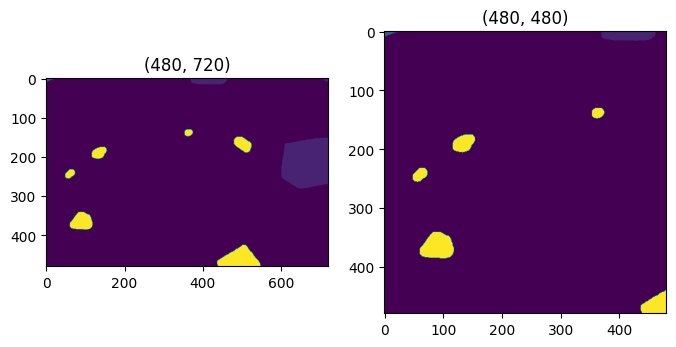

In [7]:
# Mask with original size and after cropping
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_data = ((sample_mask_arr, sample_mask_cropped),
            (sample_mask_arr.shape, sample_mask_cropped.shape))

for (ax, arr, title) in zip(axes,*(plot_data)) :
    ax.imshow(arr)
    ax.set_title(title)


In [8]:
# Check the unique values in cropped_mask
np.unique(sample_mask_cropped)

array([0.    , 0.0721, 0.2125, 0.7154])

In [9]:
# What happens if you divide them with 0.07?
np.unique(sample_mask_cropped)//0.07

array([ 0.,  1.,  3., 10.])

In [10]:
# We need to convert the values of 3 to 2 and 10 to 3 after floor operation with 0.07
adjusted_mask = sample_mask_cropped//0.07
adjusted_mask[adjusted_mask == 3.0] = 2.0
adjusted_mask[adjusted_mask == 10.0] = 3.0
print(np.unique(adjusted_mask))

[0. 1. 2. 3.]


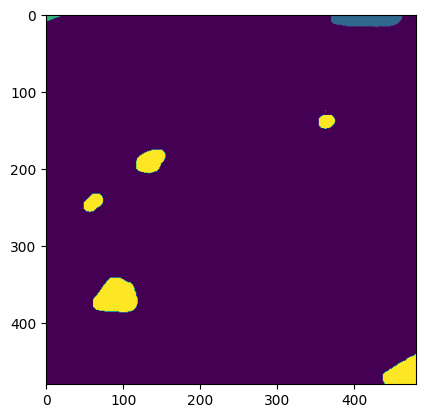

In [11]:
# Check if any changes in the output (the colors are a bit different! as pixel values changed)
plt.imshow(adjusted_mask)

In [12]:
adjusted_mask.shape

(480, 480)

In [13]:
# Get 4 channel one hot encoded mask
final_sample_mask = to_categorical(adjusted_mask,num_classes=4)
final_sample_mask

array([[[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0.

In [14]:
final_sample_mask.shape

(480, 480, 4)

### Excercise to get from one hot to integer encoded mask (post processing)

In [15]:
int_encoded_mask = np.argmax(final_sample_mask, axis=-1)
int_encoded_mask

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3]])

In [16]:
int_encoded_mask.shape

(480, 480)

In [17]:
np.unique(int_encoded_mask)

array([0, 1, 2, 3])

In [18]:
# A dummy 4 channel array
np.random.seed(42)
dum_arr = np.random.rand(3, 3, 4)
dum_arr

array([[[0.37454012, 0.95071431, 0.73199394, 0.59865848],
        [0.15601864, 0.15599452, 0.05808361, 0.86617615],
        [0.60111501, 0.70807258, 0.02058449, 0.96990985]],

       [[0.83244264, 0.21233911, 0.18182497, 0.18340451],
        [0.30424224, 0.52475643, 0.43194502, 0.29122914],
        [0.61185289, 0.13949386, 0.29214465, 0.36636184]],

       [[0.45606998, 0.78517596, 0.19967378, 0.51423444],
        [0.59241457, 0.04645041, 0.60754485, 0.17052412],
        [0.06505159, 0.94888554, 0.96563203, 0.80839735]]])

In [19]:
# First row has max value of 0.95 on index 1, hence, 1 is returned on (0,0)
# Similarly, second row has max value of 0.86 on index 3, hence 3 is returned for (0,1)
# So on ...
np.argmax(dum_arr, axis=-1)

array([[1, 3, 3],
       [0, 1, 0],
       [1, 2, 2]])

## Creating the Dataset

In [20]:
# Parameters 
batch_size = 16
dims = (480, 480)
num_classes = 4

# Dataset Creation
train_dataset = LunarDataset(X_train, y_train, batch_size, dims, num_classes)
valid_dataset = LunarDataset(X_valid, y_valid, batch_size, dims, num_classes)

## Let's visualize our masks

In [21]:
# Taking a sample batch from train_dataset
batch = next(iter(train_dataset)) # Batch Size, Height, Width, Channels (Images, Masks)

# Check the shape of batch created --> Images and Masks
print(batch[0].shape) # 16 images in a batch
print(batch[1].shape) # 16 respective masks in a batch

(16, 480, 480, 3)
(16, 480, 480, 4)


In [22]:
# Get the mask
sample = batch[1][1] # Second in the batch

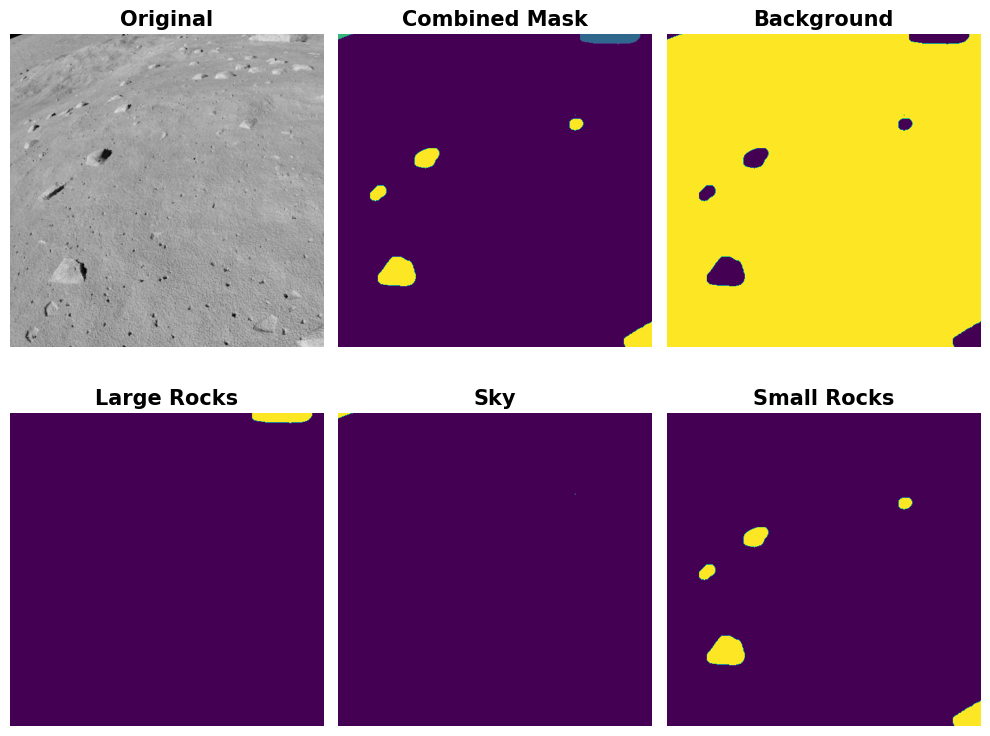

In [23]:
# Creating Subplot for better visualization
fig, ((a1, a2, a3), (a4, a5, a6)) = plt.subplots(2, 3, figsize = (10, 8))

# For different axes and titles
for i, (ax,title) in enumerate(zip((a1, a2, a3, a4, a5, a6),
                                   ('Original', 'Combined Mask', 'Background', 'Large Rocks', 'Sky', 'Small Rocks'))):
    if i == 0:
        ax.imshow(batch[0][1])                    # Second Image in the batch (Original)
    elif i == 1:
        ax.imshow(np.argmax(sample, axis=-1))     # Converts One Hot encoded mask to Integer Encoded Mask (single channel)
    else: 
        ax.imshow(sample[:, :, i-2])              # Channel Wise Output from Mask

    # Set Title and turn off the axis
    ax.set_title(title, fontsize=15, weight='bold')
    ax.axis('off')

# Adjust Layout and Display the Subplot
plt.tight_layout()
plt.show()

### Let's check out some basic steps of transfer learning using a pretrained model (VGG16)


## segmentation_models


**segmentation_models** is a python library with Neural Networks for Image Segmentation based on Keras and TensorFlow.

The main features of this library are:

* High level API (just two lines of code to create model for segmentation)
* 4 models architectures for binary and multi-class image segmentation (including legendary Unet)
* 25 available backbones for each architecture
* All backbones have pre-trained weights for faster and better convergence
* Helpful segmentation losses (Jaccard, Dice, Focal) and metrics (IoU, F-score)

In [24]:
# run this command to directly install the library in our notebook

!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 836.5 kB/s eta 0:00:000:00:01


* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [25]:
# By default it tries to import keras, if it is not installed, it will try to start with tensorflow.keras framework
os.environ["SM_FRAMEWORK"] = "tf.keras" # Set the environment variable SM_FRAMEWORK to "tf.keras"
import segmentation_models as sm        # It will import without any errors if env variable is set properly
sm.set_framework('tf.keras')            # Use segmentation_models library and set the framework to TensorFlow's Keras

Segmentation Models: using `tf.keras` framework.


In [26]:
# Set the last axis of the tensor as channel axis
tf.keras.backend.set_image_data_format('channels_last')
# Explicitly setting this is not always necessary, as 'channels_last' is the default setting

# Building our UNet model with segmentation_models

In [27]:
# Parameters for UNET using Segmentation Models
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'


# Even though backbone doesn't have encoder-decoder structure, it is still able to build it thanks to sm library
model = sm.Unet(backbone_name = BACKBONE,
               input_shape = input_shape,
               classes = n_classes,
               activation = activation)
#                 encoder_weights = 'imagenet',
#                 encoder_freeze = True)

# Check all the different parameters of UNET, try with them
# Uncomment the above two lines of UNET for transfer learning

# Check the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 480, 480,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 480, 480,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 480, 480,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 240, 240,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 240, 240,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 240, 240,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 120, 120,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 120, 120,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 120, 120,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 120, 120,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 60, 60,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 60, 60,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 60, 60,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 60, 60,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 30, 30,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 30, 30,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 30, 30,    │  2,359,808 │ block5_conv1[0][

 Total params: 23,752,708 (90.61 MB)

 Trainable params: 23,748,676 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

## Compile model

In [28]:
""" Hyperparameters """
lr = 1e-4
batch_size = 16
epochs = 5

# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5)]

# compiling the model --> Try changing the loss function to jacard_loss from sm library and see changes!
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr),
              metrics = metrics)

# Steps per epoch (training in batches)
train_steps = len(X_train)//batch_size
valid_steps = len(X_valid)//batch_size


""" Callbacks """
callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_iou_score',
            mode = 'max',
            patience = 2,
            factor = 0.1,
            verbose = 1,
            min_lr = 1e-6
        ),

        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_iou_score',
            patience = 3,
            mode = 'max',
            verbose = 1
        )
    ]


model is compiled with **loss**="categorical_crossentropy",  **optimizer**=Adam, **metrics**=iou_score

**Callbacks** is a tool to customize the behavior of a Keras model during training, evaluation, or inference.

**ReduceLROnPlateau:** Reduce learning rate when a metric has stopped improving.

**EarlyStopping:** Stop training when a monitored metric has stopped improving.

## Train model

In [30]:
# Fitting the model
model_history = model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks,
    )

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 822s 2s/step - iou_score: 0.3238 - loss: 0.8648 - val_iou_score: 0.5043 - val_loss: 0.2154 - learning_rate: 1.0000e-04
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 770s 2s/step - iou_score: 0.5481 - loss: 0.1778 - val_iou_score: 0.5744 - val_loss: 0.1614 - learning_rate: 1.0000e-04
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 772s 2s/step - iou_score: 0.5944 - loss: 0.1408 - val_iou_score: 0.7518 - val_loss: 0.1086 - learning_rate: 1.0000e-04
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 770s 2s/step - iou_score: 0.7546 - loss: 0.1130 - val_iou_score: 0.7647 - val_loss: 0.1130 - learning_rate: 1.0000e-04
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - iou_score: 0.7755 - loss: 0.1033 - val_iou_score: 0.7869 - val_loss: 0.0982 - learning_rate: 1.0000e-04


## Predict from model

In [39]:
# function to predict result
def predict_image(img_path, mask_path, model):
    ## Basic Setup
    H = 480
    W = 480
    num_classes = 4
    
    ## Read Images and Preprocess
    img = imread(img_path)
    img = img[:W, :H]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask and Preprocess
    mask = imread(mask_path, as_gray = True)
    mask = mask[:W, :H]

    ## Prediction mask and Postprocess
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    ## Calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum()/union.sum()

    return img, mask, pred_mask, iou

In [59]:
X_test[0], y_test[0]

('/kaggle/input/images/render/render9763.png',
 '/kaggle/input/images/clean/clean9763.png')

In [43]:
from tensorflow.keras.models import load_model, save_model

In [44]:
# Save the Model
save_model(model, 'LunarModel.h5')

In [45]:
# Load the Model
loaded_model = load_model('/kaggle/working/LunarModel.h5')

In [67]:
_, _, _, iou_score = predict_image(img_path, mask_path, loaded_model)
print(iou_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0.9333562349708004


### You can see we have reached a satisfactory result for our project.